This is the main model for our project, which incorporates a basic ResNet framework along with the integration of a Squeeze and Excitation Block.

This code is built after references from the following repositories :

https://github.com/Nikunj-Gupta/Efficient_ResNets/tree/master

https://github.com/kuangliu/pytorch-cifar

In [ ]:
#importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms


import os
import argparse

from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms
import random
import numpy as np

In [ ]:
#Checking th availability of a GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [ ]:
import torchvision
from torchvision import datasets, transforms

# Defining our transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.95, 1.0), ratio=(0.9, 1.1), interpolation=2),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Creating datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Creating dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:12<00:00, 13150623.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Taking the generic basic block of a Residual Network and adding SE block to its implementation

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, conv_kernel_size=3, shortcut_kernel_size=1, drop=0.4):

        super(BasicBlock, self).__init__()
        self.drop = drop
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=conv_kernel_size, stride=stride, padding=int(conv_kernel_size/2), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=conv_kernel_size,stride=1, padding=int(conv_kernel_size/2), bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=shortcut_kernel_size, stride=stride, padding=int(shortcut_kernel_size/2), bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        if self.drop: self.dropout = nn.Dropout(self.drop)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        if self.drop: out = self.dropout(out)
        return out

def conv1x1(in_channels,
            out_channels,
            stride=1,
            groups=1,
            bias=False):

    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)

class SEBlock(nn.Module):

    def __init__(self,
                 channels,
                 reduction=16):
        super(SEBlock, self).__init__()
        mid_cannels = channels // reduction

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=channels,
            out_channels=mid_cannels,
            bias=True)
        self.activ = nn.ReLU(inplace=True)

        self.conv2 = conv1x1(
            in_channels=mid_cannels,
            out_channels=channels,
            bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        return x

class ResNet(nn.Module):
    def __init__(
            self,
            block,
            num_blocks,
            conv_kernel_sizes=None,
            shortcut_kernel_sizes=None,
            num_classes=10,
            num_channels=32,
            avg_pool_kernel_size=4,
            drop=None,
            squeeze_and_excitation=None):
        super(ResNet, self).__init__()
        self.in_planes = num_channels
        # self.avg_pool_kernel_size = avg_pool_kernel_size
        self.avg_pool_kernel_size = int(32 / (2**(len(num_blocks)-1)))


        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.num_channels)

        self.drop = drop
        self.squeeze_and_excitation = squeeze_and_excitation

        if self.squeeze_and_excitation:
            self.seblock = SEBlock(channels=self.num_channels)


        self.residual_layers = []
        for n in range(len(num_blocks)):
            stride = 1 if n==0 else 2 # stride=1 for first residual layer, and stride=2 for the remaining layers
            conv_kernel_size = conv_kernel_sizes[n] if conv_kernel_sizes else 3 # setting default kernel size of block's convolutional layers
            shortcut_kernel_size = shortcut_kernel_sizes[n] if shortcut_kernel_sizes else 1 # setting default kernel size of block's skip connection (shortcut) layers
            self.residual_layers.append(self._make_layer(
                                                    block,
                                                    self.num_channels*(2**n),
                                                    num_blocks[n],
                                                    stride=stride,
                                                    conv_kernel_size=conv_kernel_size,
                                                    shortcut_kernel_size=shortcut_kernel_size))

        self.residual_layers = nn.ModuleList(self.residual_layers)
        self.linear = nn.Linear(self.num_channels*(2**n)*block.expansion, num_classes)

        if self.drop:
            self.dropout = nn.Dropout(self.drop) # Define proportion or neurons to dropout

    def _make_layer(self, block, planes, num_blocks, stride, conv_kernel_size, shortcut_kernel_size):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, conv_kernel_size, shortcut_kernel_size, drop=self.drop))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.squeeze_and_excitation: out = self.seblock(out)
        for layer in self.residual_layers:
            out = layer(out)

        out = F.avg_pool2d(out, self.avg_pool_kernel_size)
        out = out.view(out.size(0), -1)
        if self.drop: out = self.dropout(out)
        out = self.linear(out)
        return out



In [ ]:
model=ResNet(
            block=BasicBlock,
            num_blocks=[4, 4, 3],
            conv_kernel_sizes=[3, 3, 3],
            shortcut_kernel_sizes=[1, 1, 1] ,
            num_channels=64,
            avg_pool_kernel_size=8,
            drop=0,
            squeeze_and_excitation=1
        )


In [ ]:
#defining our model
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (seblock): SEBlock(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (conv1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
    (activ): ReLU(inplace=True)
    (conv2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (residual_layers): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_siz

In [ ]:
#Calculating the number of parameters
def count_trainable_parameters(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)


print(f"The model has {count_trainable_parameters(model)} trainable parameters.") # printing the output of the function




The model has 4697742 trainable parameters.


In [ ]:
#Lookahead
from collections import defaultdict
from itertools import chain
from torch.optim import Optimizer
import torch
import warnings

class Lookahead(Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha

        self.param_groups = self.optimizer.param_groups
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0
    def zero_grad(self):
        self.optimizer.zero_grad()

    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)

    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

In [ ]:
#defining the loss and optimizer function
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9,weight_decay=5e-4)


optimizer = Lookahead(optimizer, k=5, alpha=0.5)
scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=0.001)



In [ ]:
#Training and evaluation loop
epochs=200
steps=0
grad_clip=0.1
test_accplt=[]

train_losses=[]
test_losses=[]
for e in range(epochs):
    train_loss=0.0
    test_loss=0.0
    model.train()
    for images,labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        if grad_clip:
          nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        train_loss+=loss.item()*images.size(0)

    model.eval()
    test_acc=[]
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        predictions = torch.argmax(output, dim=1)
        test_loss += loss.item() * images.size(0)
        k=torch.sum(predictions == labels)

        val = 100*(k/len(images))

        test_acc.append(val)


    scheduler.step()



    train_loss=train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)

    test_loss=test_loss/len(test_loader.sampler)
    test_losses.append(test_loss)

    test_accuracy=(sum(test_acc)/len(test_acc)).item()
    test_accplt.append(test_accuracy)



    print('Epoch:{}\tTraining Loss : {:.6f}\t test Loss :{:.6f}'.format(
          e+1,
          train_loss,
          test_loss


      ))
    print('accuracy :',(sum(test_acc)/len(test_acc)).item())


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch:1	Training Loss : 1.742420	 test Loss :1.396548
accuracy : 50.04999923706055
Epoch:2	Training Loss : 1.280283	 test Loss :1.220227
accuracy : 58.71999740600586
Epoch:3	Training Loss : 0.992828	 test Loss :0.967167
accuracy : 66.43999481201172
Epoch:4	Training Loss : 0.820576	 test Loss :0.685093
accuracy : 76.69999694824219
Epoch:5	Training Loss : 0.702124	 test Loss :0.891728
accuracy : 70.55999755859375
Epoch:6	Training Loss : 0.626280	 test Loss :0.506619
accuracy : 83.18999481201172
Epoch:7	Training Loss : 0.572652	 test Loss :0.523418
accuracy : 82.05999755859375
Epoch:8	Training Loss : 0.535554	 test Loss :0.489555
accuracy : 83.16999816894531
Epoch:9	Training Loss : 0.492377	 test Loss :0.486170
accuracy : 83.5
Epoch:10	Training Loss : 0.473003	 test Loss :0.731425
accuracy : 76.72999572753906
Epoch:11	Training Loss : 0.444066	 test Loss :0.407898
accuracy : 86.18999481201172
Epoch:12	Training Loss : 0.431165	 test Loss :0.392397
accuracy : 86.73999786376953
Epoch:13	Train

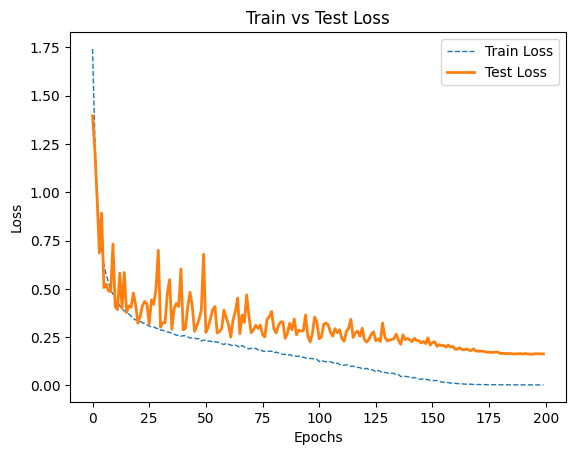

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_losses and test_losses are lists of losses per epoch
plt.plot(train_losses, label='Train Loss', linestyle='--', linewidth=1)  # Dashed line for train losses
plt.plot(test_losses, label='Test Loss', linestyle='-', linewidth=2)  # Bold line for test losses

# Adding legends to differentiate the lines
plt.legend()

# Labeling the axes
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')    # Label for the y-axis

# You can also add a title to the plot if needed
plt.title('Train vs Test Loss')

# Display the plot
plt.show()


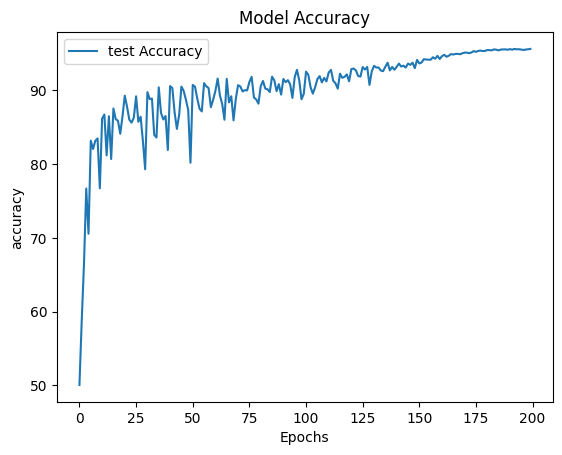

In [ ]:
#plotting the accuracy over 200 epochs
plt.plot(test_accplt,label='test Accuracy')
# Adding legends to differentiate the lines
plt.legend()

# Labeling the axes
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('accuracy')    # Label for the y-axis

# You can also add a title to the plot if needed
plt.title('Model Accuracy')

# Display the plot
plt.show()

In [ ]:
 #applying data augmentation on the no labels dataset
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import pickle
import os

# Transformation for no-labels data, using the same as test transformation
transform_no_label = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


class CIFARNoLabels(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_data = self.data[idx]
        image = Image.fromarray(image_data)

        if self.transform:
            image = self.transform(image)

        return idx, image  # Return both index and image

# Function to load your no-labels data
def load_cifar_no_labels_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')

    images = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images

cifar_no_labels_data = load_cifar_no_labels_batch('/content/cifar_test_nolabels.pkl')


no_labels_dataset = CIFARNoLabels(cifar_no_labels_data, transform=transform_no_label)


no_labels_loader = DataLoader(no_labels_dataset, batch_size=100, shuffle=False, num_workers=2)





In [ ]:
#creating predictions CSV
import torch
import pandas as pd

# Ensure the model is in evaluation mode
model.eval()

# Store predictions
predictions = []

# No need to track gradients for inference
with torch.no_grad():
    # Iterate over the DataLoader
    for batch in no_labels_loader:
        img_ids, images = batch  # Extract img_ids and images from the batch
        images = images.to(device)  # Move images to the device

        # Get predictions from the model
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)

        # Extend the list with tuples of image ID and predicted class index
        batch_predictions = zip(img_ids.tolist(), predicted_classes.tolist())
        predictions.extend(batch_predictions)

# Convert predictions to a DataFrame and save as a CSV
predictions_df = pd.DataFrame(predictions, columns=['ID', 'Label'])
predictions_df.to_csv('predictions.csv', index=False)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
#printing the final accuracy of the model
test_acc=[]
model.eval()
for images,labels in test_loader:
    with torch.no_grad():
      labels = labels.to(device)
      outputs = model(images.to(device))
      prediction = torch.argmax(outputs, dim=1)
      k=torch.sum(prediction == labels)

      val = 100*(k/len(images.to(device)))

      test_acc.append(val)
print('accuracy :',(sum(test_acc)/len(test_acc)).item())

accuracy : 95.63999938964844


In [26]:
#To create model check point after training

torch.save(model.state_dict(), 'lat_model')


<All keys matched successfully>

In [ ]:
#to load the model
best_model= ResNet(
            block=BasicBlock,
            num_blocks=[4, 4, 3],
            conv_kernel_sizes=[3, 3, 3],
            shortcut_kernel_sizes=[1, 1, 1] ,
            num_channels=64,
            avg_pool_kernel_size=8,
            drop=0,
            squeeze_and_excitation=1
        )

best_model.load_state_dict(torch.load('lat_model'))
best_model.to(device)